In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.layers import LSTM, RepeatVector, TimeDistributed, Dense
from tensorflow.keras.callbacks import EarlyStopping, Callback, ModelCheckpoint
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler


import os
import joblib
from typing import Tuple, List, Union, Dict

2025-06-08 13:19:48.750773: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-06-08 13:19:48.764923: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749363588.781920   59237 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749363588.786256   59237 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1749363588.799072   59237 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

# I. Data Preparation

In [2]:
class DataPreprocessor:
    """Handles data preprocessing for time series anomaly detection"""
    
    def __init__(self, window_size: int = 30, stride: int = 5):
        self.window_size = window_size
        self.stride = stride
        self.scaler = MinMaxScaler()

    def create_sequences(self, data: pd.DataFrame) -> np.ndarray:
        """Create sliding window sequences from time series data"""
        sequences = []
        for i in range(0, len(data) - self.window_size + 1, self.stride):
            sequences.append(data.iloc[i:i + self.window_size].values)
        return np.array(sequences)
    
    def fit_scaler(self, data: pd.DataFrame) -> pd.DataFrame:
        """Fit scaler on training data and transform"""
        scaled_data = self.scaler.fit_transform(data)
        return pd.DataFrame(scaled_data, columns=data.columns, index=data.index)
    
    def transform(self, data: pd.DataFrame) -> pd.DataFrame:
        """Transform data using fitted scaler"""
        if self.scaler is None:
            raise ValueError("Scaler not fitted. Call fit_scaler first.")
        scaled_data = self.scaler.transform(data)
        return pd.DataFrame(scaled_data, columns=data.columns, index=data.index)
    
    def split_sequences(self, sequences: np.ndarray, train_size: float = 0.9) -> Tuple[np.ndarray, np.ndarray]:
        """Split sequences into train, validation, and test sets"""
        total_len = len(sequences)
        train_end = int(train_size * total_len)

        return sequences[:train_end], sequences[train_end:]

# II. Model Architecture

In [3]:
class LSTMAutoEncoder(Model):
    """LSTM-based Autoencoder for anomaly detection"""
    
    def __init__(self, window_size: int, n_features: int, 
                 encoder_units: List[int] = [32, 16], 
                 decoder_units: List[int] = [16, 32]):
        super().__init__()
        self.window_size = window_size
        self.n_features = n_features

        # Encoder
        self.encoder_lstm1 = LSTM(encoder_units[0], return_sequences=True, activation='relu')
        self.encoder_lstm2 = LSTM(encoder_units[1], return_sequences=False, activation='relu')

        # Decoder
        self.repeat_vector = RepeatVector(window_size)
        self.decoder_lstm1 = LSTM(decoder_units[0], return_sequences=True, activation='relu')
        self.decoder_lstm2 = LSTM(decoder_units[1], return_sequences=True, activation='relu')
        self.output_layer = TimeDistributed(Dense(n_features))

    def call(self, inputs, training=False):
        # Encoder
        x = self.encoder_lstm1(inputs, training=training)
        encoded = self.encoder_lstm2(x, training=training)

        # Decoder
        x = self.repeat_vector(encoded)
        x = self.decoder_lstm1(x, training=training)
        x = self.decoder_lstm2(x, training=training)
        decoded = self.output_layer(x)
        return decoded

# III. Callback Function

In [4]:
class TrainingCallback(Callback):
    """callback for monitoring training progress"""
    
    def __init__(self, plot_interval: int = 10, save_plots: bool = False):
        super().__init__()
        self.plot_interval = plot_interval
        self.save_plots = save_plots
        if save_plots:
            os.makedirs("models/training_plots", exist_ok=True)
        
    def on_epoch_end(self, epoch, logs=None):
        if (epoch + 1) % self.plot_interval == 0:
            self._plot_progress(epoch, logs)
    
    def _plot_progress(self, epoch, logs):
        """Plot training progress"""
        plt.figure(figsize=(12, 5))
        
        # Get history from model
        history = self.model.history.history
        
        plt.plot(history['loss'], label='Train Loss')
        plt.plot(history['val_loss'], label='Val Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title(f'Training Progress - Epoch {epoch+1}')
        plt.legend()
        plt.grid(True, alpha=0.3)
        
        plt.tight_layout()
        
        if self.save_plots:
            plt.savefig(f"models/training_plots/progress_epoch_{epoch+1}.png", dpi=150, bbox_inches='tight')
        plt.show()

# IV. Pipeline

In [5]:
class AnomalyDetector:
    """Main class for LSTM Autoencoder-based anomaly detection"""
    
    def __init__(self, window_size: int = 30, stride: int = 5, save_path: str = "models"):
        self.window_size = window_size
        self.stride = stride
        self.preprocessor = DataPreprocessor(window_size, stride)
        self.model = None
        self.threshold = None
        self.history = None
        self.feature_names = None

        # Make a folder for saving models
        if not os.path.exists(save_path):
            os.makedirs(save_path)
        
        self.save_path = save_path
                
    def build_model(self, n_features: int, encoder_units: List[int] = [64, 32], 
                   decoder_units: List[int] = [32, 64]):
        """Build and compile the LSTM autoencoder model"""
        self.model = LSTMAutoEncoder(
            window_size=self.window_size,
            n_features=n_features,
            encoder_units=encoder_units,
            decoder_units=decoder_units
        )
        self.model.compile(optimizer='adam', loss='mse', metrics=['mse'])
        
    def prepare_data(self, data: pd.DataFrame, fit_scaler: bool = True) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
        """Prepare data for training"""
        # Store feature names for later use
        self.feature_names = data.columns.tolist()
        
        # Scale data
        if fit_scaler:
            scaled_data = self.preprocessor.fit_scaler(data)
        else:
            scaled_data = self.preprocessor.transform(data)
        
        # Create sequences
        sequences = self.preprocessor.create_sequences(scaled_data)
        
        # Split data
        X_train, X_val = self.preprocessor.split_sequences(sequences)
        
        return X_train, X_val
        
    def train(self, X_train: np.ndarray, X_val: np.ndarray, 
              epochs: int = 50, batch_size: int = 32, patience: int = 10,
              save_best: bool = True, plot_progress: bool = True) -> tf.keras.callbacks.History:
        """Train the autoencoder model"""
        if self.model is None:
            raise ValueError("Model not built. Call build_model() first.")
        
        callbacks = [
            EarlyStopping(monitor='val_loss', patience=patience, restore_best_weights=True)
        ]
        
        if save_best:
            callbacks.append(
                ModelCheckpoint(f"{self.save_path}/best_model.keras", monitor='val_loss', 
                              save_best_only=True, verbose=1)
            )
            
        if plot_progress:
            callbacks.append(TrainingCallback(plot_interval=max(1, epochs//5), save_plots=True))
        
        print(f"Training model with {len(X_train)} training samples...")
        self.history = self.model.fit(
            X_train, X_train,
            validation_data=(X_val, X_val),
            epochs=epochs,
            batch_size=batch_size,
            callbacks=callbacks,
            verbose=1
        )
        
        return self.history
    
    def calculate_threshold(self, X_train: np.ndarray, percentile: float = 95) -> float:
        """Calculate anomaly detection threshold from training data"""
        if self.model is None:
            raise ValueError("Model not trained. Train model first.")
            
        print("Calculating threshold from training data...")
        train_pred = self.model.predict(X_train, verbose=0)
        train_errors = self._calculate_errors(X_train, train_pred)
        
        self.threshold = np.percentile(train_errors, percentile)
        
        print(f"Threshold set to: {self.threshold:.6f}")
        print(f"Training errors - Mean: {np.mean(train_errors):.6f}, Std: {np.std(train_errors):.6f}")
        
        return self.threshold
    
    def _calculate_errors(self, original: np.ndarray, reconstructed: np.ndarray) -> np.ndarray:
        """Calculate reconstruction errors"""
        return np.array([
            mean_squared_error(orig.flatten(), recon.flatten())
            for orig, recon in zip(original, reconstructed)
        ])
    
    def calculate_feature_importance(self, X: np.ndarray, method: str = 'reconstruction_error', 
                                   top_k: int = None, normalize: bool = True) -> Dict:
        """
        Calculate feature importance for anomaly detection
        
        Parameters:
        -----------
        X : np.ndarray
            Input sequences with shape (n_samples, window_size, n_features)
        method : str
            Method to calculate importance ('reconstruction_error', 'gradient', 'permutation')
        top_k : int, optional
            Return only top k most important features
        normalize : bool
            Whether to normalize importance scores to sum to 1
            
        Returns:
        --------
        Dict containing feature importance scores and rankings
        """
        if self.model is None:
            raise ValueError("Model not trained. Train model first.")
            
        n_features = X.shape[2]
        feature_names = self.feature_names or [f'Feature_{i}' for i in range(n_features)]
        
        if method == 'reconstruction_error':
            importance_scores = self._calculate_reconstruction_importance(X)
        elif method == 'gradient':
            importance_scores = self._calculate_gradient_importance(X)
        elif method == 'permutation':
            importance_scores = self._calculate_permutation_importance(X)
        else:
            raise ValueError("Method must be 'reconstruction_error', 'gradient', or 'permutation'")
        
        # Normalize if requested
        if normalize:
            importance_scores = importance_scores / np.sum(importance_scores)
        
        # Create results dictionary
        feature_importance = dict(zip(feature_names, importance_scores))
        
        # Sort by importance
        sorted_features = sorted(feature_importance.items(), key=lambda x: x[1], reverse=True)
        
        # Apply top_k filter if specified
        if top_k is not None:
            sorted_features = sorted_features[:top_k]
        
        results = {
            'feature_importance': dict(sorted_features),
            'importance_scores': importance_scores,
            'feature_names': feature_names,
            'method': method,
            'top_features': [item[0] for item in sorted_features],
            'top_scores': [item[1] for item in sorted_features]
        }
        
        return results
    
    def _calculate_reconstruction_importance(self, X: np.ndarray) -> np.ndarray:
        """Calculate importance based on per-feature reconstruction errors"""
        predictions = self.model.predict(X, verbose=0)
        
        # Calculate MSE for each feature across all samples and time steps
        feature_errors = np.mean(np.mean((X - predictions) ** 2, axis=0), axis=0)
        
        return feature_errors
    
    def _calculate_gradient_importance(self, X: np.ndarray) -> np.ndarray:
        """Calculate importance based on gradient magnitudes"""
        import tensorflow as tf
        
        # Sample a subset for gradient calculation (for efficiency)
        sample_size = min(1000, len(X))
        sample_indices = np.random.choice(len(X), sample_size, replace=False)
        X_sample = X[sample_indices]
        
        gradients = []
        
        for i in range(len(X_sample)):
            with tf.GradientTape() as tape:
                x_input = tf.Variable(X_sample[i:i+1], dtype=tf.float32)
                prediction = self.model(x_input)
                loss = tf.reduce_mean(tf.square(x_input - prediction))
            
            grad = tape.gradient(loss, x_input)
            gradients.append(np.abs(grad.numpy()))
        
        # Average gradients across samples and time steps
        avg_gradients = np.mean(np.concatenate(gradients, axis=0), axis=(0, 1))
        
        return avg_gradients
    
    def _calculate_permutation_importance(self, X: np.ndarray) -> np.ndarray:
        """Calculate importance based on permutation method"""
        # Calculate baseline reconstruction error
        baseline_pred = self.model.predict(X, verbose=0)
        baseline_error = np.mean(self._calculate_errors(X, baseline_pred))
        
        n_features = X.shape[2]
        importance_scores = np.zeros(n_features)
        
        # For each feature, permute it and measure the change in error
        for feature_idx in range(n_features):
            X_permuted = X.copy()
            
            # Permute the feature across samples
            for sample_idx in range(len(X)):
                perm_indices = np.random.permutation(len(X))
                X_permuted[sample_idx, :, feature_idx] = X[perm_indices[sample_idx], :, feature_idx]
            
            # Calculate error with permuted feature
            permuted_pred = self.model.predict(X_permuted, verbose=0)
            permuted_error = np.mean(self._calculate_errors(X_permuted, permuted_pred))
            
            # Importance is the increase in error
            importance_scores[feature_idx] = permuted_error - baseline_error
        
        # Ensure non-negative scores
        importance_scores = np.maximum(importance_scores, 0)
        
        return importance_scores
    
    def visualize_feature_importance(self, X: np.ndarray, method: str = 'reconstruction_error', 
                                 top_k: int = 15, figsize: tuple = (12, 8)):
        """
        Visualize feature importance scores
        
        Parameters:
        -----------
        X : np.ndarray
            Input sequences
        method : str
            Method to calculate importance
        top_k : int
            Number of top features to display
        figsize : tuple
            Figure size for the plot
        """
        results = self.calculate_feature_importance(X, method=method, top_k=top_k)

        features = results['top_features']
        scores = results['top_scores']

        fig, ax = plt.subplots(figsize=figsize)
        fig.suptitle(f'Feature Importance Analysis ({method.replace("_", " ").title()})', fontsize=16)

        ax.barh(range(len(features)), scores, color='skyblue')
        ax.set_yticks(range(len(features)))
        ax.set_yticklabels(features)
        ax.set_xlabel('Importance Score')
        ax.set_title(f'Top {len(features)} Most Important Features')
        ax.invert_yaxis()
        ax.grid(True, alpha=0.3)

        plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust for suptitle
        plt.show()

        # Print summary
        print(f"\n=== Feature Importance Summary ({method}) ===")
        print(f"Method: {method.replace('_', ' ').title()}")
        print(f"Total features: {len(results['importance_scores'])}")
        print(f"Top {min(5, len(features))} most important features:")
        for i, (feature, score) in enumerate(zip(features[:5], scores[:5])):
            print(f"  {i+1}. {feature}: {score:.6f}")

    def predict(self, X: np.ndarray, return_details: bool = False) -> Union[np.ndarray, Dict]:
        """Predict anomalies in new data"""
        if self.model is None or self.threshold is None:
            raise ValueError("Model not trained or threshold not set.")
        
        predictions = self.model.predict(X, verbose=0)
        errors = self._calculate_errors(X, predictions)
        anomalies = errors > self.threshold
        
        if not return_details:
            return anomalies
            
        return {
            'anomalies': anomalies,
            'errors': errors,
            'threshold': self.threshold,
            'num_anomalies': np.sum(anomalies),
            'anomaly_rate': np.mean(anomalies),
            'max_error': np.max(errors),
            'mean_error': np.mean(errors)
        }
    
    def visualize_results(self, X: np.ndarray, title: str = "Anomaly Detection Results"):
        """Visualize reconstruction errors and anomalies"""
        if self.model is None:
            raise ValueError("Model not trained.")
            
        predictions = self.model.predict(X, verbose=0)
        errors = self._calculate_errors(X, predictions)
        
        fig, axes = plt.subplots(2, 2, figsize=(15, 10))
        fig.suptitle(title, fontsize=16)
        
        # Error timeline
        axes[0, 0].plot(errors, alpha=0.7)
        if self.threshold:
            axes[0, 0].axhline(y=self.threshold, color='red', linestyle='--', label='Threshold')
            anomalies = errors > self.threshold
            axes[0, 0].scatter(np.where(anomalies)[0], errors[anomalies], 
                             color='red', s=20, alpha=0.8, label='Anomalies')
        axes[0, 0].set_title('Reconstruction Errors')
        axes[0, 0].set_xlabel('Sample')
        axes[0, 0].set_ylabel('Error')
        axes[0, 0].legend()
        axes[0, 0].grid(True, alpha=0.3)
        
        # Error distribution
        axes[0, 1].hist(errors, bins=50, alpha=0.7, edgecolor='black')
        if self.threshold:
            axes[0, 1].axvline(x=self.threshold, color='red', linestyle='--', label='Threshold')
        axes[0, 1].set_title('Error Distribution')
        axes[0, 1].set_xlabel('Error')
        axes[0, 1].set_ylabel('Frequency')
        axes[0, 1].legend()
        axes[0, 1].grid(True, alpha=0.3)
        
        # Box plot
        axes[1, 0].boxplot([errors], labels=['Errors'])
        if self.threshold:
            axes[1, 0].axhline(y=self.threshold, color='red', linestyle='--', label='Threshold')
        axes[1, 0].set_title('Error Statistics')
        axes[1, 0].set_ylabel('Error')
        axes[1, 0].grid(True, alpha=0.3)
        
        # Cumulative distribution
        sorted_errors = np.sort(errors)
        cumulative = np.arange(1, len(sorted_errors) + 1) / len(sorted_errors)
        axes[1, 1].plot(sorted_errors, cumulative)
        if self.threshold:
            axes[1, 1].axvline(x=self.threshold, color='red', linestyle='--', label='Threshold')
        axes[1, 1].set_title('Cumulative Distribution')
        axes[1, 1].set_xlabel('Error')
        axes[1, 1].set_ylabel('Cumulative Probability')
        axes[1, 1].legend()
        axes[1, 1].grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
        
        # Print summary
        print(f"\n=== {title} Summary ===")
        print(f"Samples: {len(errors)}")
        print(f"Mean error: {np.mean(errors):.6f}")
        print(f"Std error: {np.std(errors):.6f}")
        if self.threshold:
            anomalies = errors > self.threshold
            print(f"Anomalies: {np.sum(anomalies)} ({np.mean(anomalies)*100:.2f}%)")
    
    def save_model(self, filepath: str):
        """Save the trained model"""
        if self.model is None:
            raise ValueError("No model to save.")
        self.model.save(filepath)
        
        # Save additional parameters
        params = {
            'window_size': self.window_size,
            'stride': self.stride,
            'threshold': self.threshold,
            'scaler': self.preprocessor.scaler,
            'feature_names': self.feature_names
        }
        joblib.dump(params, filepath.replace('.keras', '_params.pkl'))
        print(f"Model and parameters saved to {filepath}")
    
    def load_model(self, filepath: str):
        """Load a saved model"""
        self.model = tf.keras.models.load_model(filepath)
        
        # Load additional parameters
        params_file = filepath.replace('.keras', '_params.pkl')
        if os.path.exists(params_file):
            params = joblib.load(params_file)
            self.window_size = params['window_size']
            self.stride = params['stride']
            self.threshold = params['threshold']
            self.preprocessor.scaler = params['scaler']
            self.feature_names = params.get('feature_names', None)
        
        print(f"Model loaded from {filepath}")

# V. Orchestrate

In [6]:
df = pd.read_csv("ilapak10_train.csv", index_col=0, parse_dates=True)
df.head(2)

,suhu_sealing_vertikal_bawah,suhu_sealing_vertikal_atas,suhu_sealing_horizontal_depan,suhu_sealing_horizontal_belakang,output_time_sec
times,,,,,
2024-04-17 10:46:15,209.4,174.5,174.5,209.3,7233.0
2024-04-17 10:52:15,209.5,174.5,174.4,209.4,7206.0


Preparing data...
Traing Sequences: (963, 30, 5)
Validation Sequences: (107, 30, 5)
Building model...
Model built sucessfully.

Training model...
Training model with 963 training samples...
Epoch 1/100


W0000 00:00:1749363592.306856   59237 gpu_device.cc:2341] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2025-06-08 13:20:01.909612: E tensorflow/core/util/util.cc:131] oneDNN supports DT_INT32 only on platforms with AVX-512. Falling back to the default Eigen-based implementation if present.


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step - loss: 0.2577 - mse: 0.2577
Epoch 1: val_loss improved from inf to 0.11853, saving model to models/best_model.keras
31/31 ━━━━━━━━━━━━━━━━━━━━ 15s 162ms/step - loss: 0.2552 - mse: 0.2552 - val_loss: 0.1185 - val_mse: 0.1185
Epoch 2/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - loss: 0.0664 - mse: 0.0664
Epoch 2: val_loss improved from 0.11853 to 0.06103, saving model to models/best_model.keras
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 99ms/step - loss: 0.0661 - mse: 0.0661 - val_loss: 0.0610 - val_mse: 0.0610
Epoch 3/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 243ms/step - loss: 0.0326 - mse: 0.0326
Epoch 3: val_loss improved from 0.06103 to 0.03538, saving model to models/best_model.keras
31/31 ━━━━━━━━━━━━━━━━━━━━ 8s 262ms/step - loss: 0.0325 - mse: 0.0325 - val_loss: 0.0354 - val_mse: 0.0354
Epoch 4/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - loss: 0.0243 - mse: 0.0243
Epoch 4: val_loss improved from 0.03538 to 0.03047, saving model to models/best_model.keras


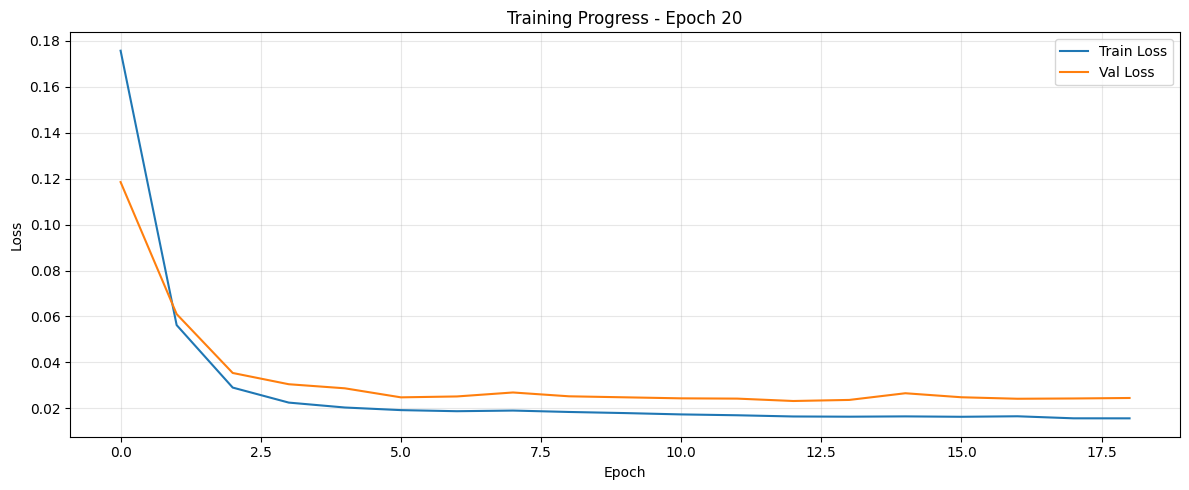

31/31 ━━━━━━━━━━━━━━━━━━━━ 5s 147ms/step - loss: 0.0166 - mse: 0.0166 - val_loss: 0.0239 - val_mse: 0.0239
Epoch 21/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - loss: 0.0155 - mse: 0.0155
Epoch 21: val_loss improved from 0.02317 to 0.02265, saving model to models/best_model.keras
31/31 ━━━━━━━━━━━━━━━━━━━━ 4s 137ms/step - loss: 0.0155 - mse: 0.0155 - val_loss: 0.0227 - val_mse: 0.0227
Epoch 22/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - loss: 0.0152 - mse: 0.0152
Epoch 22: val_loss improved from 0.02265 to 0.02214, saving model to models/best_model.keras
31/31 ━━━━━━━━━━━━━━━━━━━━ 4s 143ms/step - loss: 0.0152 - mse: 0.0152 - val_loss: 0.0221 - val_mse: 0.0221
Epoch 23/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - loss: 0.0153 - mse: 0.0153
Epoch 23: val_loss did not improve from 0.02214
31/31 ━━━━━━━━━━━━━━━━━━━━ 4s 125ms/step - loss: 0.0153 - mse: 0.0153 - val_loss: 0.0222 - val_mse: 0.0222
Epoch 24/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - loss: 0.0150 - mse: 0.0150
Epoch 

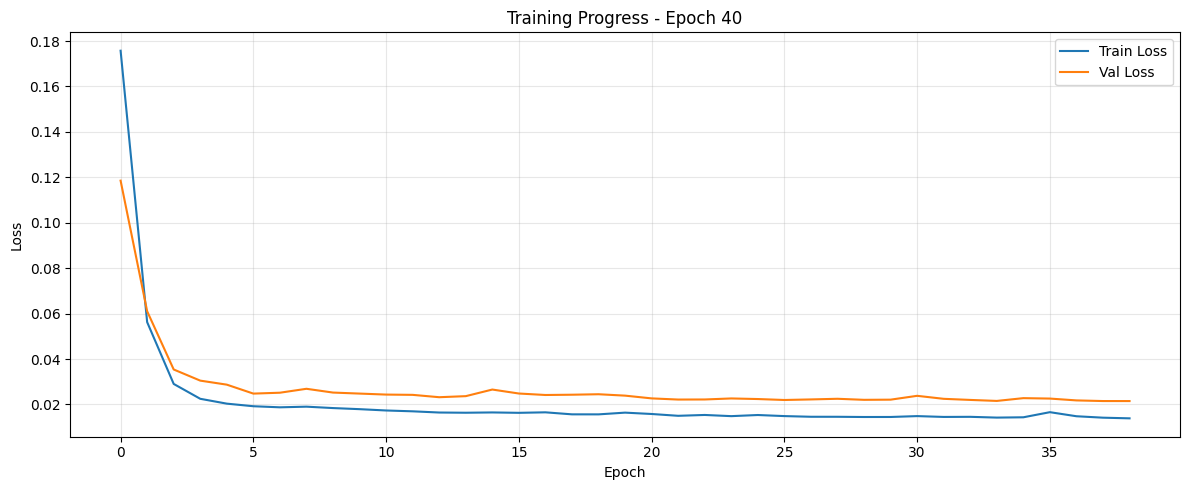

31/31 ━━━━━━━━━━━━━━━━━━━━ 5s 149ms/step - loss: 0.0133 - mse: 0.0133 - val_loss: 0.0219 - val_mse: 0.0219
Epoch 41/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step - loss: 0.0140 - mse: 0.0140
Epoch 41: val_loss did not improve from 0.02147
31/31 ━━━━━━━━━━━━━━━━━━━━ 4s 124ms/step - loss: 0.0140 - mse: 0.0140 - val_loss: 0.0244 - val_mse: 0.0244
Epoch 42/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - loss: 0.0140 - mse: 0.0140
Epoch 42: val_loss improved from 0.02147 to 0.02126, saving model to models/best_model.keras
31/31 ━━━━━━━━━━━━━━━━━━━━ 4s 144ms/step - loss: 0.0140 - mse: 0.0140 - val_loss: 0.0213 - val_mse: 0.0213
Epoch 43/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step - loss: 0.0142 - mse: 0.0142
Epoch 43: val_loss did not improve from 0.02126
31/31 ━━━━━━━━━━━━━━━━━━━━ 4s 118ms/step - loss: 0.0142 - mse: 0.0142 - val_loss: 0.0219 - val_mse: 0.0219
Epoch 44/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step - loss: 0.0144 - mse: 0.0144
Epoch 44: val_loss did not improve from 0.02126
31/

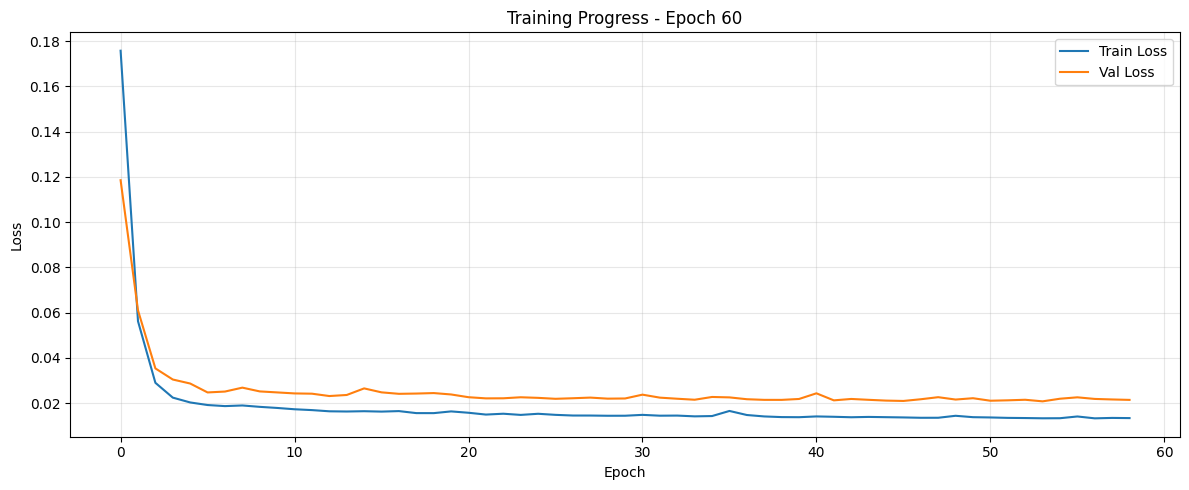

31/31 ━━━━━━━━━━━━━━━━━━━━ 6s 178ms/step - loss: 0.0129 - mse: 0.0129 - val_loss: 0.0216 - val_mse: 0.0216
Epoch 61/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step - loss: 0.0129 - mse: 0.0129
Epoch 61: val_loss did not improve from 0.02083
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 112ms/step - loss: 0.0129 - mse: 0.0129 - val_loss: 0.0218 - val_mse: 0.0218
Epoch 62/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step - loss: 0.0132 - mse: 0.0132
Epoch 62: val_loss did not improve from 0.02083
31/31 ━━━━━━━━━━━━━━━━━━━━ 4s 122ms/step - loss: 0.0132 - mse: 0.0132 - val_loss: 0.0228 - val_mse: 0.0228
Epoch 63/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - loss: 0.0133 - mse: 0.0133
Epoch 63: val_loss did not improve from 0.02083
31/31 ━━━━━━━━━━━━━━━━━━━━ 4s 130ms/step - loss: 0.0133 - mse: 0.0133 - val_loss: 0.0222 - val_mse: 0.0222
Epoch 64/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - loss: 0.0132 - mse: 0.0132
Epoch 64: val_loss did not improve from 0.02083
31/31 ━━━━━━━━━━━━━━━━━━━━ 4s 133ms/step - loss:

/tmp/ipykernel_59237/1281678007.py:328: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[1, 0].boxplot([errors], labels=['Errors'])


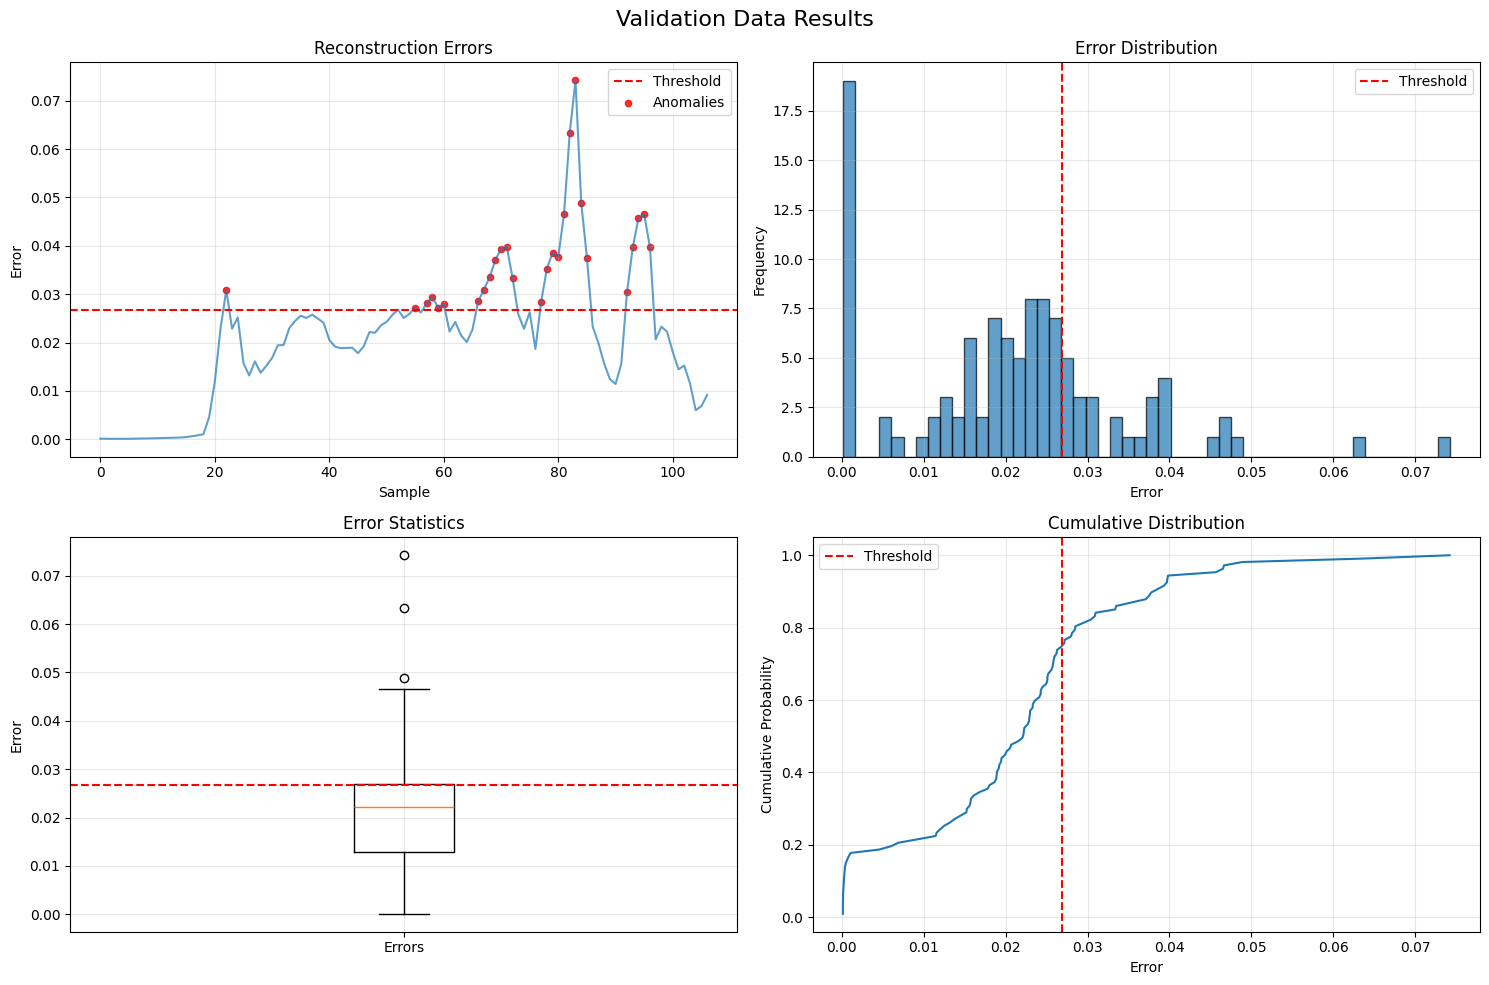


=== Validation Data Results Summary ===
Samples: 107
Mean error: 0.020829
Std error: 0.014021
Anomalies: 27 (25.23%)

Saving model...
Model and parameters saved to models/model.keras


In [7]:
pipeline = AnomalyDetector(save_path="models")
# Preparing data
print(f"Preparing data...")
X_train, X_val = pipeline.prepare_data(df, fit_scaler=True)
print(f"Traing Sequences: {X_train.shape}")
print(f"Validation Sequences: {X_val.shape}")

# Build model
print(f"Building model...")
pipeline.build_model(n_features=df.shape[1], encoder_units=[128, 64], decoder_units=[64, 128])
print(f"Model built sucessfully.\n")

# Train model
print(f"Training model...")
history = pipeline.train(X_train, X_val, epochs=100, batch_size=32, patience=10, save_best=True, plot_progress=True)
print(f"Model trained sucessfully.\n")

# Calculate threshold
print(f"Calculating threshold...")
threshold = pipeline.calculate_threshold(X_train, percentile=95)
print(f"Threshold calculated sucessfully.\n")

# Test on validation data
print(f"Testing model on validation data...")
val_results = pipeline.predict(X_val, return_details=True)
print(f"Validation anomalies detected: {val_results['num_anomalies']} ({val_results['anomaly_rate']*100:.2f}%)")

pipeline.visualize_results(X_val, "Validation Data Results")

print("\nSaving model...")
pipeline.save_model("models/model.keras")

### Features Importance

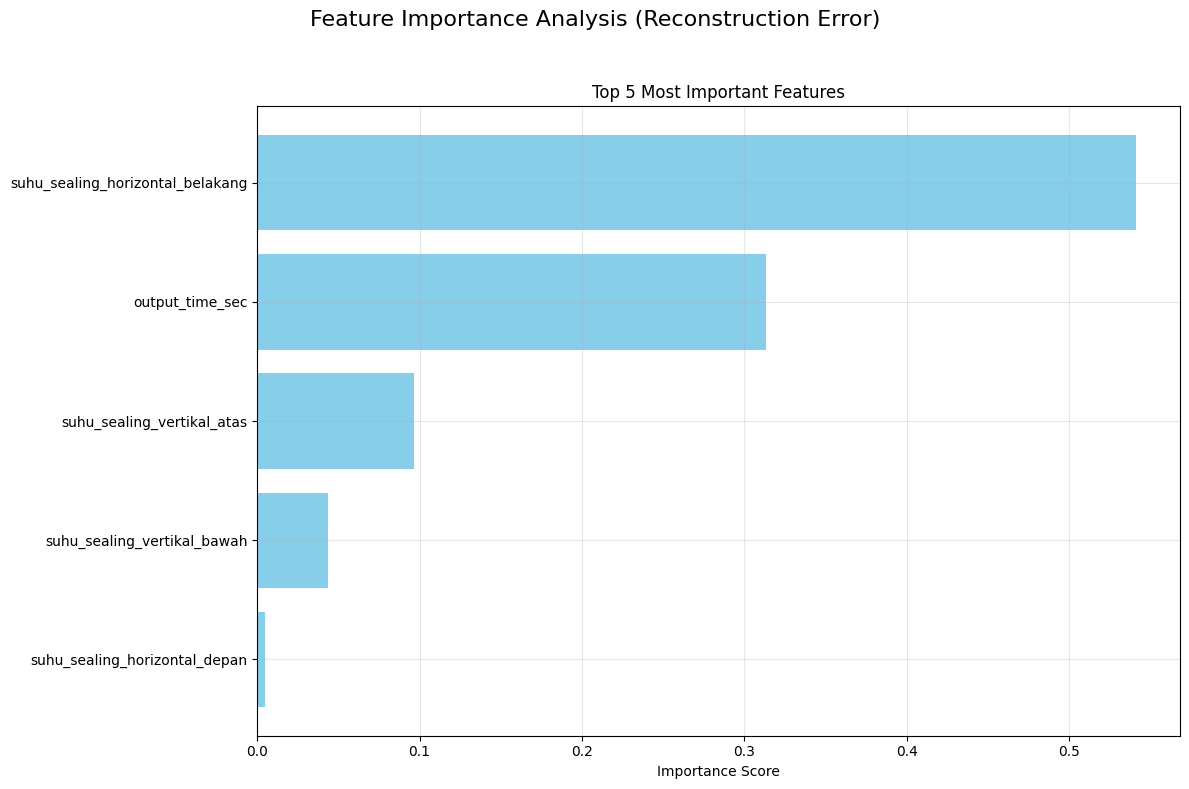


=== Feature Importance Summary (reconstruction_error) ===
Method: Reconstruction Error
Total features: 5
Top 5 most important features:
  1. suhu_sealing_horizontal_belakang: 0.541337
  2. output_time_sec: 0.313264
  3. suhu_sealing_vertikal_atas: 0.096724
  4. suhu_sealing_vertikal_bawah: 0.043798
  5. suhu_sealing_horizontal_depan: 0.004876
Top Features:  ['suhu_sealing_horizontal_belakang', 'output_time_sec', 'suhu_sealing_vertikal_atas', 'suhu_sealing_vertikal_bawah', 'suhu_sealing_horizontal_depan']
Importamce Scores:  [0.0437982  0.09672424 0.00487625 0.54133692 0.31326439]


In [8]:
results = pipeline.calculate_feature_importance(X_val, method='reconstruction_error', top_k=15)
pipeline.visualize_feature_importance(X_val, method='reconstruction_error', top_k=15)

print(f"Top Features: ", results['top_features'])
print(f"Importamce Scores: ", results['importance_scores'])

# Example Usage

In [14]:
new_data = {
    "suhu_sealing_vertikal_bawah": 209.6,
    "suhu_sealing_vertikal_atas": 159.6,
    "suhu_sealing_horizontal_depan": 160.1,
    "suhu_sealing_horizontal_belakang": 209.6,
    "output_time_sec": 0,
}
df_new = pd.DataFrame(new_data, index=[pd.Timestamp.now()])
recent_data = df.iloc[-pipeline.window_size + len(df_new):].copy()
combined_data = pd.concat([recent_data, df_new], ignore_index=True)
scaled_data = pipeline.preprocessor.transform(combined_data)
X = pipeline.preprocessor.create_sequences(scaled_data)

prediction = pipeline.predict(X[-1:], return_details=True)

result = {
        'is_anomaly': bool(prediction['anomalies'][0]),
        'reconstruction_error': float(prediction['errors'][0]),
        'threshold': float(prediction['threshold']),
        'error_vs_threshold': float(prediction['errors'][0]) / float(prediction['threshold']),
        'confidence': 'High' if abs(prediction['errors'][0] - prediction['threshold']) > prediction['threshold'] * 0.1 else 'Low'
    }

if result['is_anomaly']:
    print("Anomaly detected!")
    pipeline.visualize_feature_importance(X[-1:], method='reconstruction_error', top_k=15)
else:
    print("No anomaly detected.")

No anomaly detected.
